In [1]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Setting up device agnostic code
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
!pip install torchinfo -q

We are adding random crop and horizontal flip only to the training transforms since we use these data augmentation techniques to improve the performance of the model.

In [3]:
CIFAR_stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Using CxWxH
    transforms.Normalize(*CIFAR_stats, inplace=True),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Using CxWxH
    transforms.Normalize(*CIFAR_stats, inplace=True),

])

dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 13084302.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
val_ratio = 0.2
train_size = int((1-val_ratio) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, ([train_size, val_size]))

batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size = batch_size, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

tensor([1, 1, 3, 5, 8, 0, 7, 1, 3, 0, 5, 7, 4, 8, 8, 4, 6, 5, 9, 5, 6, 0, 0, 2,
        3, 4, 2, 1, 7, 8, 9, 9, 2, 9, 7, 2, 8, 9, 5, 8, 6, 7, 9, 8, 5, 1, 0, 9,
        9, 4, 6, 8, 3, 5, 1, 7, 2, 4, 9, 4, 9, 5, 2, 1])


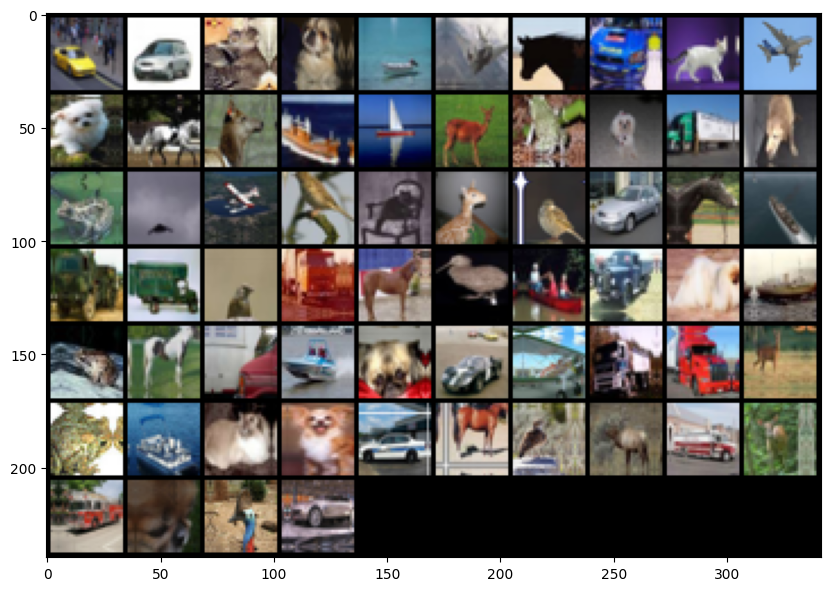

In [5]:
# returns the denormalized batch which has been permuted for matplotlib usage
def denormalize(images, means, std_devs):
  # image * std + mean
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  std_devs = torch.tensor(std_devs).reshape(1, 3, 1, 1)
  return images * std_devs + means

def show_batch(dl):
  import matplotlib.pyplot as plt
  from torchvision.utils import make_grid
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(10, 10))
    images = denormalize(images, *CIFAR_stats)
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0)) # converting to WxHxC
    print(labels)
    break

show_batch(train_dl)

## Creating the ResNet by the following sub-tasks -
1. Define the basic Residual Block.
2. Define the bottleneck Residual Block.
3. Define a ResNet class.

In [6]:
# Basic Residual Block
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion)
    )

    # Identity shortcut if stride is 1 or input and output dimensions are matching.
    self.shortcut = nn.Sequential()

    # Projection shortcut - 1x1 Convolution used to match the dimension with output otherwise.
    if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * BasicBlock.expansion)
      )

  def forward(self, x):
    f = self.residual_block(x)
    x = self.shortcut(x)
    return nn.ReLU(inplace=True)(x + f)

In [7]:
# Bottleneck Residual Block
class BottleneckBlock(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels * BottleneckBlock.expansion, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)
    )

    self.shortcut = nn.Sequential()

    # Creating projection shortcut
    if stride != 1 or in_channels != out_channels * BottleneckBlock.expansion:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BottleneckBlock.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)
      )

  def forward(self, x):
    f = self.residual_block(x)
    x = self.shortcut(x)
    return nn.ReLU(inplace=True)(f + x)

In [8]:
# ResNet
class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super().__init__()

    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.conv2_x = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.conv3_x = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.conv4_x = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.conv5_x = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride):
      strides = [stride] + [1] * (num_blocks-1)
      layers = []
      for stride in strides:
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
      return nn.Sequential(*layers)

  def forward(self, x):
    output = self.conv1(x)
    output = self.conv2_x(output)
    output = self.conv3_x(output)
    output = self.conv4_x(output)
    output = self.conv5_x(output)
    output = self.avgpool(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

In [9]:
def resnet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
  return ResNet(BottleneckBlock, [3, 4, 6, 3])

def resnet101():
  return ResNet(BottleneckBlock, [3, 4, 23, 3])

def resnet152():
  return ResNet(BottleneckBlock, [3, 8, 36, 3])

In [10]:
from torchinfo import summary
batch_size = 64
model = resnet18()
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 64, 14, 14]          9,408
│    └─BatchNorm2d: 2-2                  [64, 64, 14, 14]          128
│    └─ReLU: 2-3                         [64, 64, 14, 14]          --
├─Sequential: 1-2                        [64, 64, 14, 14]          --
│    └─BasicBlock: 2-4                   [64, 64, 14, 14]          --
│    │    └─Sequential: 3-1              [64, 64, 14, 14]          73,984
│    │    └─Sequential: 3-2              [64, 64, 14, 14]          --
│    └─BasicBlock: 2-5                   [64, 64, 14, 14]          --
│    │    └─Sequential: 3-3              [64, 64, 14, 14]          73,984
│    │    └─Sequential: 3-4              [64, 64, 14, 14]          --
├─Sequential: 1-3                        [64, 128, 7, 7]           --
│  

# Creating the training and testing loops -

In [11]:
# Helper function to calculate training time.
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):

  """Prints difference between start and end time"""
  total_time = end - start
  print(f'Train time on {device}: {total_time:3f} seconds')
  return total_time

def accuracy_fn(y_true, y_preds):
  correct_labels = torch.eq(y_true, y_preds).sum().item()
  acc = correct_labels / (len(y_preds))
  return acc

In [12]:
# Training and Validation for 1 epoch.
def train_step(model: torch.nn.Module,
               train_dl: torch.utils.data.DataLoader,
               val_dl: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler,
               accuracy_fn,
               device: torch.device):

  train_loss, train_acc = 0, 0
  val_loss, val_acc = 0, 0

  model.to(device)

  ### Training
  model.train()

  # Loop through all the batches in the dataloader
  for batch, (images, labels) in enumerate(train_dl):
    images, labels = images.to(device), labels.to(device)
    logits = model(images)
    loss = loss_fn(logits, labels)  # Calculate the loss
    train_loss += loss.item() # Accumulate the loss
    train_acc += accuracy_fn(labels, logits.argmax(dim=1)) # Accumulate accuracy
    optimizer.zero_grad() # Set gradients to zero
    loss.backward() # delta Loss / delta weights
    optimizer.step()  # adjust the weights
    scheduler.step()  # adjust the learning rate

  # Calculate the avg loss / batch when all the batches have been passed through
  train_loss = train_loss / len(train_dl)
  train_acc = train_acc / len(train_dl)

  ### Validation
  model.eval()  # Evaluation mode
  with torch.inference_mode():
    for batch, (val_imgs, val_labels) in enumerate(val_dl):
      val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
      val_logits = model(val_imgs)
      loss = loss_fn(val_logits, val_labels)
      val_loss += loss.item()
      val_acc += accuracy_fn(val_labels, val_logits.argmax(dim=1))

  # Calculate average validation loss, accuracy when all batches of passed through.
  val_loss = val_loss / len(val_dl)
  val_acc = val_acc / len(val_dl)

  return train_loss, train_acc, val_loss, val_acc

In [13]:
# Testing for 1 epoch.
def test_step(model: torch.nn.Module,
              test_dl: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):

  test_loss, test_acc = 0, 0

  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (images, labels) in enumerate(test_dl):
      images, labels = images.to(device), labels.to(device)
      test_logits = model(images)
      test_loss += loss_fn(test_logits, labels).item()
      test_acc += accuracy_fn(labels, test_logits.argmax(dim=1))

  test_loss /= len(test_dl)
  test_acc /= len(test_dl)

  return test_loss, test_acc

In [14]:
######## Training Function ########
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          max_lr: float,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module,
          accuracy_fn,
          epochs: int = 2):

  training_start_time = timer()

  training_results = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': []
  }

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc, val_loss, val_acc = train_step(model, train_dl, val_dl, loss_fn, optimizer, scheduler, accuracy_fn, device)
    print(f'Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}')

    training_results['train_loss'].append(train_loss)
    training_results['train_acc'].append(train_acc)
    training_results['val_loss'].append(val_loss)
    training_results['val_acc'].append(val_acc)

  training_end_time = timer()
  print(f'Total training time: {print_train_time(training_start_time, training_end_time)}')
  return training_results

In [15]:
######## Testing Function ########
from tqdm.auto import tqdm

def test(model: torch.nn.Module,
         test_dl: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn):

  test_loss, test_acc = test_step(model, test_dl, loss_fn, accuracy_fn, device)
  print(f'test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}')

  test_results = {
      'test_loss': test_loss,
      'test_acc': test_acc
  }

  return test_results

In [21]:
epochs = 30
max_lr = 1e-3

model = resnet18()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
loss_fn = nn.CrossEntropyLoss()

In [22]:
training_results = train(model, train_dl, val_dl, max_lr, optimizer, scheduler, loss_fn, accuracy_fn, epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6728 | train_acc: 0.3841 | val_loss: 1.4720 | val_acc: 0.4649
Epoch: 2 | train_loss: 1.4018 | train_acc: 0.4893 | val_loss: 1.3515 | val_acc: 0.5126
Epoch: 3 | train_loss: 1.2499 | train_acc: 0.5487 | val_loss: 1.1828 | val_acc: 0.5749
Epoch: 4 | train_loss: 1.1171 | train_acc: 0.6013 | val_loss: 1.0432 | val_acc: 0.6292
Epoch: 5 | train_loss: 1.0122 | train_acc: 0.6427 | val_loss: 1.0540 | val_acc: 0.6283
Epoch: 6 | train_loss: 0.9219 | train_acc: 0.6750 | val_loss: 0.9116 | val_acc: 0.6833
Epoch: 7 | train_loss: 0.8514 | train_acc: 0.7023 | val_loss: 1.3208 | val_acc: 0.5951
Epoch: 8 | train_loss: 0.7940 | train_acc: 0.7238 | val_loss: 0.7845 | val_acc: 0.7242
Epoch: 9 | train_loss: 0.7268 | train_acc: 0.7477 | val_loss: 0.7747 | val_acc: 0.7361
Epoch: 10 | train_loss: 0.6748 | train_acc: 0.7652 | val_loss: 0.7084 | val_acc: 0.7514
Epoch: 11 | train_loss: 0.6270 | train_acc: 0.7845 | val_loss: 0.7308 | val_acc: 0.7560
Epoch: 12 | train_loss: 0.5894 | train_ac

In [23]:
test_results = test(model, test_dl, loss_fn, accuracy_fn)

test_loss: 0.3545 | test_acc: 0.8913
